## Keltner_channel
The strategy behind KC
https://www.youtube.com/watch?v=Zz4t2FaBhiI

In [1]:
import pandas as pd
from core.trade_service.instruments.moving_averages import MA
import matplotlib.pyplot as plt
import numpy as np

## ATR

In [535]:
data = pd.read_csv('../../data/BTCUSDT-1h-data.csv')
data.loc[:, 'timestamp'] = pd.to_datetime(data.timestamp)
data = data.loc[(data.timestamp.dt.year==2021) & (data.timestamp.dt.month==1), ]
data = data.set_index('timestamp')

In [658]:
def TR_single(row):
    """
    True value
    """
    return max(
        np.abs(row.high - row.low),
        np.abs(row.high - row.close_lag1),
        np.abs(row.close_lag1 - row.low)
    )

def TR(data):
    data.loc[:, 'close_lag1'] = data.close.shift()
    return data.apply(TR_single, axis=1)

def ATR(data, atr_tf=10):
    """
    Average True Value
    https://en.wikipedia.org/wiki/Average_true_range
    
    """
    data = data.copy()
    atr = [np.NaN] * (atr_tf -1)
    tr = TR(data)
    atr.append(np.mean(tr[:atr_tf])) # first values is the median of the first tf values
    i = atr_tf
    while i < len(data):
        atr.append(((atr[-1] * (atr_tf-1)) + tr[i])/atr_tf)
        i += 1
    return np.array(atr)


#### Tests

In [657]:
open_ = [120.17,121.31,121.91,123.09,122.79,122.07,120.46,120.33,119.95,121.51,119.22,119.35,118.74,118.42]
high = [120.74,121.71,121.94,123.31,123.16,122.08,120.91,120.69,120.71,121.88,119.5,119.5,118.84,118.46]
low = [120.06,121.19,121.58,122.77,122.02,120.95,120.4,120.27,119.92,119.57,119.13,119.24,118.33,118.07]
close = [120.72,121.61,121.73,123.1,122.45,121.65,120.54,120.36,120.48,119.82,119.32,119.34,118.43,118.18]
TR_ = [0.99,0.36,1.58,1.14,1.5,1.25,0.42,0.79,2.31,0.69,0.26,1.01,0.39]
STR = [1.114,1.166,1.178,1.02,1.254,1.092,0.894,1.012,0.932]
ATR_ = [1.114,1.1412,0.99696,0.955568,1.226454,1.119164,0.947331,0.959865,0.845892]

In [640]:
temp = pd.DataFrame(data={'open':open_, 'high':high, 'low':low, 'close':close})
#TR(temp)[2:] == TR_

In [653]:
temp.loc[:,'TR'] = [np.NaN] + TR(temp).round(2).tolist()[1:]
SMA(temp, 'TR', 5)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5     1.114
6     1.166
7     1.178
8     1.020
9     1.254
10    1.092
11    0.894
12    1.012
13    0.932
Name: TR, dtype: float64

In [654]:
WMA(temp, 'TR', 5)

array([       nan,        nan,        nan,        nan,        nan,
       1.114     , 1.1412    , 0.99696   , 0.955568  , 1.2264544 ,
       1.11916352, 0.94733082, 0.95986465, 0.84589172])

Ploting

In [541]:
data.loc[:, 'ATR'] = ATR(data, 14)

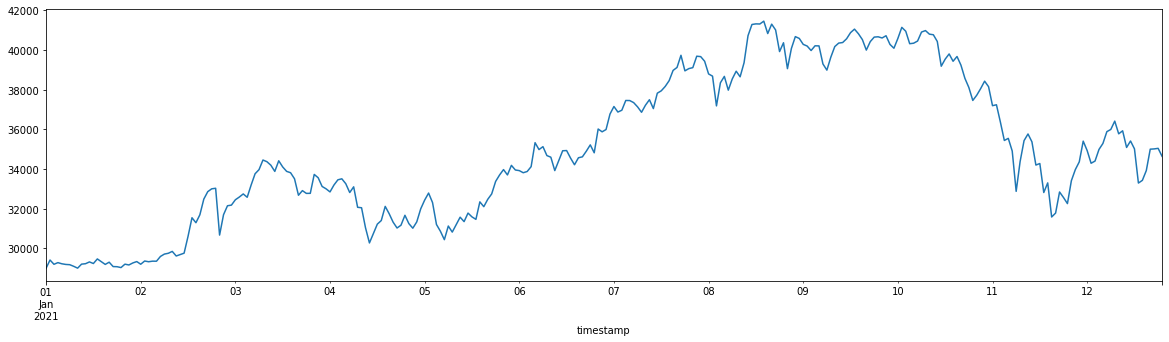

<AxesSubplot:xlabel='timestamp'>

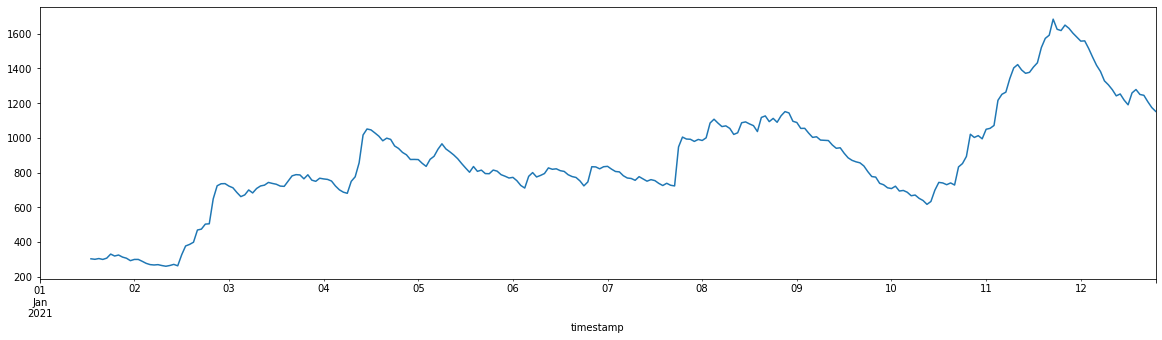

In [542]:
data.close.plot(figsize=(20,5)); plt.show()
data.ATR.plot(figsize=(20,5))

## KELT

In [668]:
data = pd.read_csv('../../data/BTCUSDT-1h-data.csv')
data.loc[:, 'timestamp'] = pd.to_datetime(data.timestamp)
data = data.loc[(data.timestamp.dt.year==2021) & (data.timestamp.dt.month==1), ]
data = data.set_index('timestamp')

In [672]:
def KELT(data, atr_tf, ema_tf, band_width):
    """
    Keltner Channel
        https://en.wikipedia.org/wiki/Keltner_channel
        https://www.youtube.com/watch?v=7PDUdm7inRk
    """
    data = data.copy()
    atr = ATR(data, atr_tf)
    data.loc[:, 'ATR'] = atr
    ema = np.array(EMA(data, 'close', tf=ema_tf))
    return ema + band_width*atr, ema, ema - band_width*atr

In [678]:
u,m,l = KELT(data, 20, 14, 1)

No handles with labels found to put in legend.


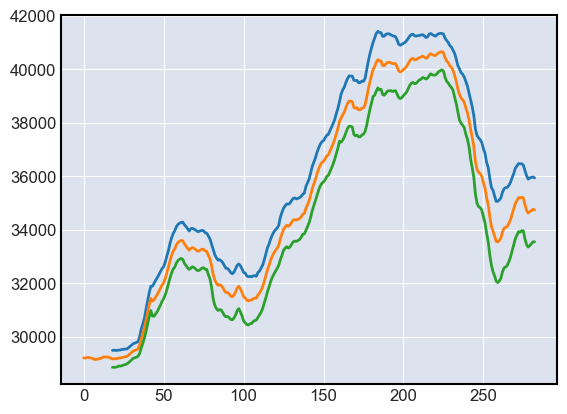

In [688]:
start = 1
end = 5000
#data.iloc[start:end].reset_index(drop=True).close.plot(color='black', figsize=(20,10))
#mpf.plot(data,type='candle')
plt.plot(u[start:end])
plt.plot(m[start:end])
plt.plot(l[start:end])
plt.legend()

In [2]:
data = pd.read_csv('../../data/BTCUSDT-1h-data.csv')
data.loc[:, 'timestamp'] = pd.to_datetime(data.timestamp)
data = data.loc[(data.timestamp.dt.year==2021) & (data.timestamp.dt.month==1), ]

In [3]:
data = data.reset_index().rename(columns={'index':'day_num'})

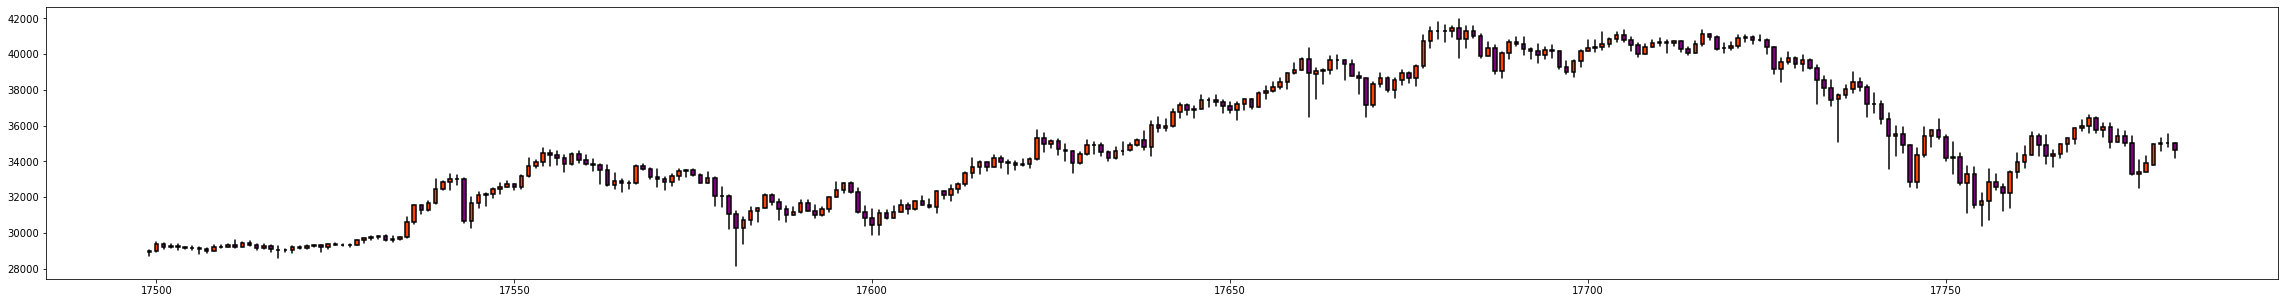

In [7]:
import matplotlib as mpl

# Function to draw candlestick
def draw_candlestick(axis, data, color_up, color_down):
    
    # Check if stock closed higher or not
    if data['close'] > data['open']:
        color = color_up
    else:
        color = color_down

    # Plot the candle wick
    axis.plot([data['day_num'], data['day_num']], [data['low'], data['high']], linewidth=1.5, color='black', solid_capstyle='round', zorder=2)
    
    # Draw the candle body
    rect = mpl.patches.Rectangle((data['day_num'] - 0.25, data['open']), 0.5, (data['close'] - data['open']), facecolor=color, edgecolor='black', linewidth=1.5, zorder=3)

    # Add candle body to the axis
    axis.add_patch(rect)
    
    # Return modified axis
    return axis



# Function to draw all candlesticks
def draw_all_candlesticks(axis, data, color_up='white', color_down='black'):
    for day in range(data.shape[0]):
        axis = draw_candlestick(axis, data.iloc[day], color_up, color_down)
    return axis

fig = plt.figure(figsize=(40, 5), facecolor='white')
ax = fig.add_subplot(111)

# Colors for candlesticks
colors = ['#ff4500', '#800080']

# Grid lines
ax.grid(linestyle='-', linewidth=2, color='white', zorder=1)

# Draw candlesticks
ax = draw_all_candlesticks(ax, data, colors[0], colors[1])


## Moving Averages 

Weighted MA and Exponetial MA
https://towardsdatascience.com/trading-toolbox-02-wma-ema-62c22205e2a9

In [488]:
data = pd.read_csv('../../data/BTCUSDT-1h-data.csv')
data.loc[:, 'timestamp'] = pd.to_datetime(data.timestamp)
#data = data.loc[(data.timestamp.dt.year==2020) & (data.timestamp.dt.month==7), ]

In [472]:
def weighted_MA(data, column, tf=10, weighted_method='linear'):
    if weighted_method == 'linear':
        weights = np.array(range(1,tf+1))
    return data[column].rolling(tf).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

In [584]:

def WMA(data, column, tf):
    """
        Wilder's Smoothing Technique
        
        WMAi = WMAi-1 + (Pricei - WMAi-1) / N

        where:
        WMAi - is the WMA value of the current period.
        WMAi-1 - is the value of the period immediately preceding the period being calculated,
        Pricei - is the source (Close or other) price of the current period.
        N - is the number of periods, over which the indicator is calculated.
        
    """
    moving_values = data.loc[:,column].values
    #counting initial NA
    count_na = 0
    for value in moving_values:
        if np.isnan(value):
            count_na += 1
        else:
            break
            
    wma = [np.NaN] * (count_na + tf -1)
    wma.append(np.mean(moving_values[count_na:count_na+tf]))     # First value simply sum of the first tf periods
    i = count_na+tf
    while(i < len(moving_values)):
        wma.append(wma[-1] + (moving_values[i] - wma[-1]) / tf)
        i += 1 
    return np.array(wma)

def test_wma():
    input_values =  [81.59,81.06,82.87,83.00,83.61,83.15,82.84,83.99,84.55,84.36,85.53,86.54,86.89,87.77,87.29]
    output_values = [                        82.43,82.57,82.62,82.90,83.23,83.45,83.87,84.40,84.90,85.47,85.84]

    temp = pd.DataFrame(input_values, columns=['input'])
    return np.round(WMA(temp, 'input', 5), 2)
    
test_wma()

array([  nan,   nan,   nan,   nan, 82.43, 82.57, 82.62, 82.9 , 83.23,
       83.45, 83.87, 84.4 , 84.9 , 85.47, 85.84])

In [485]:
def EMA(data, column, tf):
    """
    Exponential Moving Averages
    """
    return data.loc[:, column].ewm(span=tf).mean()

In [628]:
def SMA(data, column, tf):
    """
    Simple Moving averages
    """
    return data.loc[:, column].rolling(window=tf).mean()

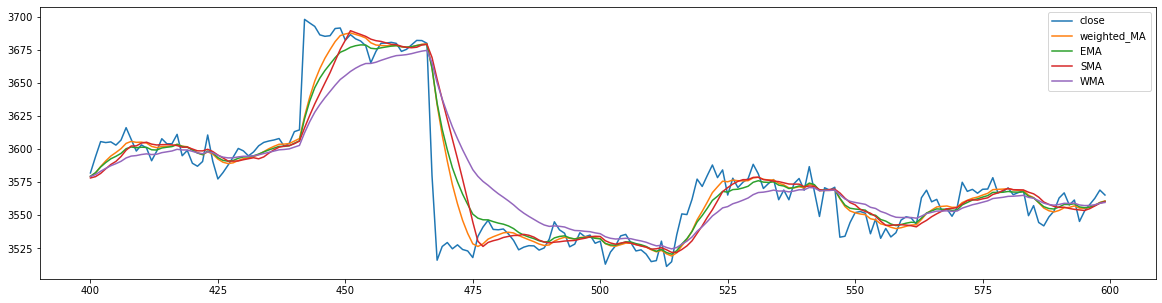

In [493]:
start=400
end=600
data.loc[:, 'weighted_MA'] = weighted_MA(data, 'close', 10)
data.loc[:, 'EMA'] = EMA(data, 'close', 10)
data.loc[:, 'SMA'] = SMA(data, 'close', 10)
data.loc[:, 'WMA'] = WMA(data, 'close', 10)

data.iloc[start:end].close.plot(figsize=(20,5))
data.iloc[start:end].weighted_MA.plot()
data.iloc[start:end].EMA.plot()
data.iloc[start:end].SMA.plot()
data.iloc[start:end].WMA.plot()
plt.legend()
plt.show()

## ADX

In [543]:
import numpy as np

In [578]:
data = pd.read_csv('../../data/BTCUSDT-1h-data.csv')
data.loc[:, 'timestamp'] = pd.to_datetime(data.timestamp)

In [555]:
def PDM_single(high_lag1, high, low_lag1, low):
    """
    positive directinal movement
    """
    if (high - high_lag1) > (low_lag1 - low):
        return (high - high_lag1)
    else:
        return 0
    
def NDM_single(high_lag1, high, low_lag1, low):
    """
    negative directinal movement
    """
    if (low_lag1 - low) > (high - high_lag1):
        return (low_lag1 - low)
    else:
        return 0
    

def PDM(data):
    """
    apply of positive directional movement
    """
    data.loc[:, 'high_lag1'] = data.high.shift()
    data.loc[:, 'low_lag1'] = data.low.shift()
    return data.apply(lambda row: PDM_single(row.high_lag1, row.high, row.low_lag1, row.low), axis=1)

def NDM(data):
    """
    apply of negative directional movement
    """
    data.loc[:, 'high_lag1'] = data.high.shift()
    data.loc[:, 'low_lag1'] = data.low.shift()
    return data.apply(lambda row: NDM_single(row.high_lag1, row.high, row.low_lag1, row.low), axis=1)

In [556]:
def PDI(data, mdi_tf=14):
    data = data.copy()
    data.loc[:,'PDM'] = PDM(data)
    return WMA(data, 'PDM', mdi_tf) * 100 / ATR(data,atr_tf=mdi_tf)

def NDI(data, mdi_tf=14):
    data = data.copy()
    data.loc[:,'NDM'] = NDM(data)
    return WMA(data, 'NDM', mdi_tf) * 100 / ATR(data,atr_tf=mdi_tf)


In [579]:
def ADX(data, adx_tf=14):
    """
    https://blog.quantinsti.com/adx-indicator-python/
    https://www.youtube.com/watch?v=laMart4lKcU
    
    Welles Wilder created the directional movement indicator and the ADX indicator to determine the direction as well as the strength of the trend. 
    According to Welles Wilder, the directional movement indicator is said to consist of the following components: the True Range, 
    Smoothed Plus Directional Indicator (+DI) and Smoothed Minus Directional Indicator (-DI).

    The ADX indicator is calculated as the smoothed average of the difference between the +DI indicator and the -DI indicator, 
    thus telling us the strength of the trend.

    The ADX indicator has a value between 0 and 100. It is generally agreed that if the ADX is above 25, it is a sign of a strong trend.
    """
    data = data.copy()
    data.loc[:,'PDI'] = PDI(data)
    data.loc[:,'NDI'] = NDI(data)
    data.loc[:, 'DX'] = np.abs((data.PDI - data.NDI)/(data.PDI + data.NDI))
    return WMA(data, 'DX', adx_tf) * 100

In [589]:
#data.loc[:, 'PDI'] = PDI(data,)
#data.loc[:, 'NDI'] = NDI(data)
data.loc[:, 'ADX'] = ADX(data, adx_tf=14)
data = data.loc[(data.timestamp.dt.year==2021) & (data.timestamp.dt.month==1), ]
data = data.set_index('timestamp')

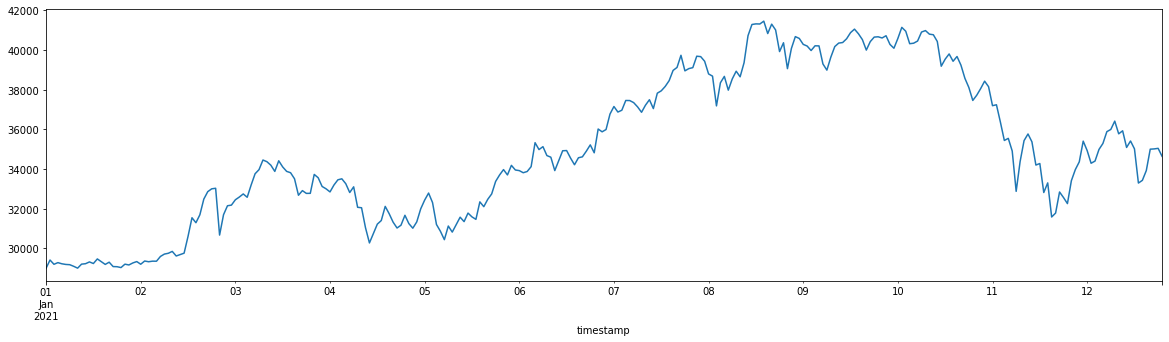

<AxesSubplot:xlabel='timestamp'>

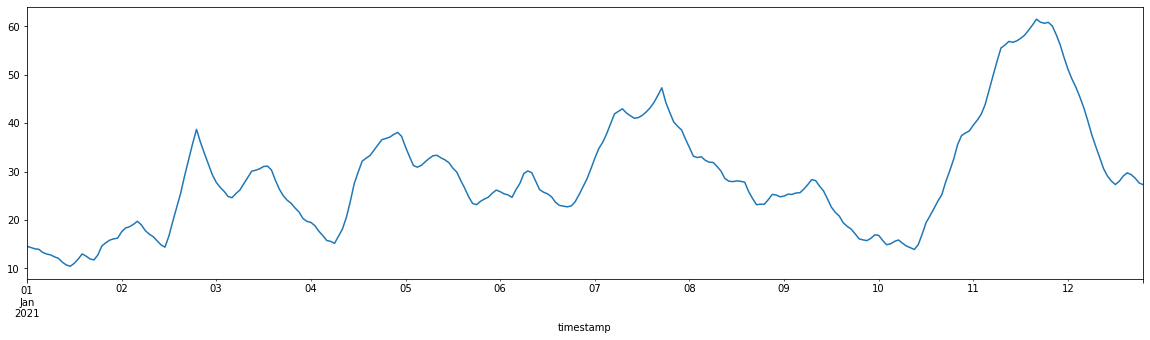

In [590]:
data.close.plot(figsize=(20,5)); plt.show()
data.ADX.plot(figsize=(20,5))
#data.PDI.plot(figsize=(20,5))
#data.NDI.plot(figsize=(20,5))